In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
import time
from datetime import timedelta

from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2.robjects.numpy2ri
import pandas as pd
from rpy2.robjects import pandas2ri
rstanarm = importr('rstanarm')
rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal, MOG
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConditionalFixedNorm, ConstrainedAnglesSigmoid, ResidualNetInput, ClampedAngles
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

In [3]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
def load_diabetes_dataset(device='cuda'):
    df = load_diabetes()
    scaler = StandardScaler()
    X_np = scaler.fit_transform(df.data)
    y_np = scaler.fit_transform(df.target.reshape(-1, 1))[:, 0]
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np).float().to(device)

    # compute regression parameters
    reg = LinearRegression().fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")
    sigma_regr = np.sqrt(np.mean(np.square(y_np - X_np @ reg.coef_)))
    print(f"Sigma regression: {sigma_regr:.4f}")
    print(f"Norm coefficients: {np.linalg.norm(reg.coef_):.4f}")

    return X_tensor, y_tensor, X_np, y_np

In [4]:
def log_likelihood(beta, sigma, X, y):

    eps = 1e-7
    log_lk = - 0.5 * (y - beta @ X.T).square().sum(-1) / (sigma**2 + eps)
    log_lk_const = - X.shape[0] * torch.log((sigma + eps) * np.sqrt(2. * np.pi))

    return log_lk + log_lk_const

def log_prior_beta(beta, lamb):

    lamb_ = 10 ** lamb
    log_prior_DE = - (lamb_) * beta.abs().sum(-1)
    log_prior_const = beta.shape[-1] * torch.log(0.5 * lamb_)

    return log_prior_DE + log_prior_const

def log_unnorm_posterior(beta, X, y, sigma, lamb):

    log_likelihood_ = log_likelihood(beta, sigma, X, y)
    log_prior_beta_ = log_prior_beta(beta, lamb)

    return log_likelihood_ + log_prior_beta_


In [5]:
def build_cond_flow_manifold (flow_dim, q, n_layers=3, context_features=16, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        transformation_layers.append(RandomPermutation(features=flow_dim-1))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features,
                                             context_features=context_features, num_blocks=5, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
            InverseTransform(
                ActNorm(features=flow_dim-1)
            )
        )

    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    # transformation_layers.append(
    #     InverseTransform(
    #         ClampedAngles(eps=1e-3)
    #     )
    # )
    
    transformation_layers.append(
        InverseTransform(
            ConditionalFixedNorm(q=q)
        )
    )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # define embedding (conditional) network
    embedding_net = ResidualNetInput(in_features=1, out_features=context_features, hidden_features=256,
                                    num_blocks=3, activation=torch.nn.functional.relu)

    # combine into a flow
    flow = Flow(transform, base_dist, embedding_net=embedding_net).to(device)
    
    return flow

def train_cond_manifold_model(model, X, y, sigma, epochs=2_001, lr=1e-3, sample_size=1, context_size=1_000, norm_min=-1, norm_max=1., T0=5, Tn=1e-2, iter_per_cool_step=20, device="cuda", **kwargs,):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # set up cooling schedule
    num_iter = epochs // iter_per_cool_step
    cooling_function = gen_cooling_schedule(T0=T0, Tn=Tn, num_iter=num_iter - 1, scheme='exp_mult')

    loss, loss_T = [], []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            T = cooling_function(epoch // (epochs / num_iter))
            optimizer.zero_grad()
            
            rand_norm = torch.rand(context_size).to(device)
            # log_uniform_norm = 10 ** (rand_norm * (norm_max_exp - norm_min_exp) + norm_min_exp).view(-1, 1)
            uniform_norm = (rand_norm * (norm_max - norm_min) + norm_min).view(-1, 1)

            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size, context=uniform_norm)
            if torch.any(torch.isnan(q_samples)): breakpoint()

            log_lik = log_likelihood(beta=q_samples, sigma=sigma, X=X, y=y)
            kl_div = torch.mean(q_log_prob - log_lik/ T)
            kl_div.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), .1)
            optimizer.step()

            loss.append(torch.mean(q_log_prob - log_lik).cpu().detach().numpy())
            loss_T.append(torch.mean(q_log_prob - log_lik/T).cpu().detach().numpy())
            print(f"Training loss at step {epoch}: {loss[-1]:.1f} and {loss_T[-1]:.1f} * (T = {T:.3f})")

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss, loss_T

def sample_beta(model, X, y, sigma, norm_min, norm_max, context_size=10, sample_size=100, n_iter=100, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    sample_list, kl_list, norm_list = [], [], []
    eps = 1e-7
    for _ in tqdm.tqdm(range(n_iter)):
        rand_norm = torch.rand(context_size).to(device)
        uniform_norm = (rand_norm * (norm_max - norm_min) + norm_min).view(-1, 1)
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size, context=uniform_norm)
        sample_list.append(posterior_samples.cpu().detach().numpy())
        norm_list.append(uniform_norm.view(-1).cpu().detach().numpy())
        log_lik = log_likelihood(beta=posterior_samples, sigma=sigma, X=X, y=y)
        kl_div = log_probs_samples - log_lik
        kl_list.append(kl_div.cpu().detach().numpy())

    sample_list, norm_list, kl_list = np.concatenate(sample_list, 0), np.concatenate(norm_list, 0), np.concatenate(kl_list, 0)

    norm_sorted_idx = norm_list.argsort()
    samples_sorted, norm_sorted, kl_sorted = sample_list[norm_sorted_idx], norm_list[norm_sorted_idx], kl_list[norm_sorted_idx]

    return samples_sorted, norm_sorted, kl_sorted

def plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=1, a=0.95, folder_name='./'):
    if norm == 2:
        alphas_ridge = np.logspace(-2, 4, 2000)
        beta_sklearn = np.array(
            [Ridge(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_ridge)])
    else:
        alphas_lasso = np.logspace(-4, 2, 2000)
        beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso)])

    sklearn_norm = np.power(np.power(np.abs(beta_sklearn), norm).sum(1), 1 / norm)

    # sklearn_norm /= sklearn_norm.max()
    sklearn_sorted_idx = sklearn_norm.argsort()
    sklearn_norm = sklearn_norm[sklearn_sorted_idx]
    sklearn_sorted = beta_sklearn[sklearn_sorted_idx]

    l_quant = np.quantile(samples_sorted, 1 - a, axis=1)
    sample_mean = np.mean(samples_sorted, axis=1)
    r_quant = np.quantile(samples_sorted, a, axis=1)
    norm_sorted_ = norm_sorted / norm_sorted.max()

    clrs = sns.color_palette("husl", X_np.shape[-1])
    fig, ax = plt.subplots(figsize=(14, 14))
    with sns.axes_style("darkgrid"):
        for i in range(sample_mean.shape[-1]):
            color = clrs[i % X_np.shape[-1]]
            ax.plot(norm_sorted, sample_mean[:, i], c=color, alpha=0.7, linewidth=1.5)
            ax.fill_between(norm_sorted, l_quant[:, i], r_quant[:, i], alpha=0.2, facecolor=color)
            ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, c=color, alpha=0.7)

        # ax.set_xscale('log')
        plt.xlabel(f'$||\beta||_{{{norm}}}$', fontsize=18)
        plt.ylabel(r'$\beta$', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # plt.xscale('log')
        # plt.savefig(f"{folder_name}beta_norm_T_001_.png", dpi=200, bbox_inches='tight')
        plt.show()

In [6]:
def build_cond_flow (flow_dim, q, n_layers=3, context_features=16, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim])

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        transformation_layers.append(RandomPermutation(features=flow_dim))

        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim, hidden_features=hidden_features,
                                             context_features=context_features, num_blocks=5, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
            InverseTransform(
                ActNorm(features=flow_dim)
            )
        )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # define embedding (conditional) network
    embedding_net = ResidualNetInput(in_features=1, out_features=context_features, hidden_features=256,
                                    num_blocks=3, activation=torch.nn.functional.relu)

    # combine into a flow
    flow = Flow(transform, base_dist, embedding_net=embedding_net).to(device)
    
    return flow

def train_cond_model(model, X, y, sigma, epochs=2_001, lr=1e-3, sample_size=1, context_size=1_000, lambda_min_exp=-2, lambda_max_exp=2., T0=5, Tn=1e-2, iter_per_cool_step=20, device="cuda", **kwargs,):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # set up cooling schedule
    num_iter = epochs // iter_per_cool_step
    cooling_function = gen_cooling_schedule(T0=T0, Tn=Tn, num_iter=num_iter - 1, scheme='exp_mult')

    loss, loss_T = [], []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            T = cooling_function(epoch // (epochs / num_iter))
            optimizer.zero_grad()
            
            rand_lambda = torch.rand(context_size).to(device)
            uniform_lambda = (rand_lambda * (lambda_max_exp - lambda_min_exp) + lambda_min_exp).view(-1, 1)

            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size, context=uniform_lambda)
            if torch.any(torch.isnan(q_samples)): breakpoint()

            log_posterior = log_unnorm_posterior(beta=q_samples, X=X, y=y, sigma=sigma, lamb=uniform_lambda)
            kl_div = torch.mean(q_log_prob - log_posterior/ T)
            kl_div.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), .1)
            optimizer.step()

            loss.append(torch.mean(q_log_prob - log_posterior).cpu().detach().numpy())
            loss_T.append(torch.mean(q_log_prob - log_posterior/T).cpu().detach().numpy())
            print(f"Training loss at step {epoch}: {loss[-1]:.1f} and {loss_T[-1]:.1f} * (T = {T:.3f})")

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss, loss_T

def sample_beta_exp(model, X, y, sigma, lambda_min_exp, lambda_max_exp, context_size=10, sample_size=100, n_iter=100, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    sample_list, kl_list, lambda_list = [], [], []

    for _ in tqdm.tqdm(range(n_iter)):
        rand_lambda = torch.rand(context_size).to(device)
        uniform_lambda = (rand_lambda * (lambda_max_exp - lambda_min_exp) + lambda_min_exp).view(-1, 1)
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size, context=uniform_lambda)
        sample_list.append(posterior_samples.cpu().detach().numpy())
        lambda_list.append((10**uniform_lambda).view(-1).cpu().detach().numpy())
        log_lik = log_likelihood(beta=posterior_samples, sigma=sigma, X=X, y=y)
        kl_div = log_probs_samples - log_lik
        kl_list.append(kl_div.cpu().detach().numpy())

    sample_list, lambda_list, kl_list = np.concatenate(sample_list, 0), np.concatenate(lambda_list, 0), np.concatenate(kl_list, 0)

    lambda_sorted_idx = lambda_list.argsort()
    samples_sorted, lambda_sorted, kl_sorted = sample_list[lambda_sorted_idx], lambda_list[lambda_sorted_idx], kl_list[lambda_sorted_idx]

    return samples_sorted, lambda_sorted, kl_sorted

def plot_betas_lambda(samples, lambdas, X_np, y_np, norm=1, a=0.95, folder_name='./'):
    if norm == 2:
        alphas_ridge = np.logspace(-2, 4, 2000)
        beta_sklearn = np.array(
            [Ridge(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_ridge)])
    else:
        alphas_lasso = np.logspace(-4, 2, 2000)
        beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso)])
        beta_sklearn_ = np.array([Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ 
                                  for alpha in tqdm.tqdm(lambdas/2/X_np.shape[0])])

    sklearn_norm = np.power(np.power(np.abs(beta_sklearn), norm).sum(1), 1 / norm)
    # sklearn_norm /= sklearn_norm.max()
    sklearn_sorted_idx = sklearn_norm.argsort()
    sklearn_norm = sklearn_norm[sklearn_sorted_idx]
    sklearn_sorted = beta_sklearn[sklearn_sorted_idx]
    
    
    l_quant = np.quantile(samples, 1 - a, axis=1)
    sample_mean = np.mean(samples, axis=1)
    r_quant = np.quantile(samples, a, axis=1)
    
    samples_norm = np.power(np.power(np.abs(sample_mean), norm).sum(-1), 1 / norm)
    samples_sorted_idx = samples_norm.argsort()
    norms_sorted = samples_norm[samples_sorted_idx]
    samples_sorted = sample_mean[samples_sorted_idx]
    r_quant_sorted = r_quant[samples_sorted_idx]
    l_quant_sorted = l_quant[samples_sorted_idx]

    clrs = sns.color_palette("husl", X_np.shape[-1])
    fig, ax = plt.subplots(figsize=(14, 14))
    with sns.axes_style("darkgrid"):
        for i in range(sample_mean.shape[-1]):
            color = clrs[i % X_np.shape[-1]]
            ax.plot(norms_sorted, samples_sorted[:, i], c=color, alpha=0.7, linewidth=1.5)
            ax.fill_between(norms_sorted, l_quant_sorted[:, i], r_quant_sorted[:, i], alpha=0.2, facecolor=color)
            ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, c=color, alpha=0.7)

        # ax.set_xscale('log')
        plt.xlabel(f'$||\beta||_{{{norm}}}$', fontsize=18)
        plt.ylabel(r'$\beta$', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        # plt.xscale('log')
        # plt.savefig(f"{folder_name}beta_norm_T_001_.png", dpi=200, bbox_inches='tight')
        plt.show()

    
    
    clrs = sns.color_palette("husl", X_np.shape[-1])
    fig, ax = plt.subplots(figsize=(14, 14))
    with sns.axes_style("darkgrid"):
        for i in range(sample_mean.shape[-1]):
            color = clrs[i % X_np.shape[-1]]
            ax.plot(lambdas, sample_mean[:, i], c=color, alpha=0.7, linewidth=1.5)
            ax.fill_between(lambdas, l_quant[:, i], r_quant[:, i], alpha=0.2, facecolor=color)
            ax.plot(lambdas, beta_sklearn_[:, i], linestyle='--', linewidth=1.5, c=color, alpha=0.7)

        # ax.set_xscale('log')
        plt.xlabel(f'$||\beta||_{{{norm}}}$', fontsize=18)
        plt.ylabel(r'$\beta$', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.xscale('log')
        # plt.savefig(f"{folder_name}beta_norm_T_001_.png", dpi=200, bbox_inches='tight')
        plt.show()
        
    return 

In [7]:
def gen_cooling_schedule(T0, Tn, num_iter, scheme):
    def cooling_schedule(t):
        if t < num_iter:
            k = t / num_iter
            if scheme == 'exp_mult':
                alpha = Tn / T0
                return T0 * (alpha ** k)
            #elif scheme == 'log_mult':
            #    return T0 / (1 + alpha * math.log(1 + k))
            elif scheme == 'lin_mult':
                alpha = (T0 / Tn - 1)
                return T0 / (1 + alpha * k)
            elif scheme == 'quad_mult':
                alpha = (T0 / Tn - 1)
                return T0 / (1 + alpha * (k ** 2))
        else:
            return Tn
    return cooling_schedule

In [8]:
device = 'cuda'
set_random_seeds(1234)

dir_name = "./plots/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# load data
X_tensor, y_tensor, X_np, y_np = load_diabetes_dataset(device=device)

# build model
flow_dim = X_tensor.shape[1]
q = 1
# flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)
flow_manifold = build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow = build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)


params_flow_manifold = dict(q=q,
                          sigma=torch.tensor(0.7),
                          lr=1e-3,
                          epochs=500,
                          T0=20,
                          Tn=1,
                          iter_per_cool_step=20,
                          norm_min=0.01,
                          norm_max=2,#.4
                          sample_size=1,
                          context_size=500,
                          device=device)

R^2 score: 0.5177
Sigma regression: 0.6944
Norm coefficients: 0.8511


In [ ]:
# torch.autograd.set_detect_anomaly(False)
flow_manifold, loss, loss_T = train_cond_manifold_model(flow_manifold, X=X_tensor, y=y_tensor, **params_flow_manifold)
torch.save(flow_manifold.state_dict(), "./models/flow_manifold_T_1")

Training loss at step 0: 850.2 and 52.6 * (T = 20.000)
Training loss at step 1: 667.3 and 43.8 * (T = 20.000)
Training loss at step 2: 610.1 and 41.6 * (T = 20.000)
Training loss at step 3: 601.7 and 41.7 * (T = 20.000)
Training loss at step 4: 588.5 and 39.0 * (T = 20.000)
Training loss at step 5: 606.3 and 40.0 * (T = 20.000)
Training loss at step 6: 607.5 and 40.1 * (T = 20.000)
Training loss at step 7: 616.3 and 40.7 * (T = 20.000)
Training loss at step 8: 604.6 and 39.1 * (T = 20.000)
Training loss at step 9: 598.4 and 40.2 * (T = 20.000)
Training loss at step 10: 588.4 and 39.2 * (T = 20.000)
Training loss at step 11: 588.1 and 39.5 * (T = 20.000)
Training loss at step 12: 588.3 and 39.4 * (T = 20.000)
Training loss at step 13: 595.9 and 39.9 * (T = 20.000)
Training loss at step 14: 592.1 and 39.3 * (T = 20.000)
Training loss at step 15: 590.2 and 39.5 * (T = 20.000)
Training loss at step 16: 593.7 and 38.9 * (T = 20.000)
Training loss at step 17: 585.7 and 38.7 * (T = 20.000)
Tr

In [ ]:
flow.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
samples_sorted, norm_sorted, kl_sorted = sample_beta(flow_manifold, X_tensor, y_tensor, sigma=params_flow_manifold['sigma'], norm_min=params_flow_manifold['norm_min'], 
                                                     norm_max=params_flow_manifold['norm_max'], context_size=1, sample_size=1000, n_iter=100, device='cuda')

In [ ]:
a = 0.95
marg_log_lik = -kl_sorted
l_quant = np.quantile(marg_log_lik, 1 - a, axis=1)
sample_mean = np.mean(marg_log_lik, axis=1)
r_quant = np.quantile(marg_log_lik, a, axis=1)

fig, ax = plt.subplots(figsize=(14, 14))
ax.plot(norm_sorted, sample_mean, alpha=0.7, linewidth=1.5)
ax.fill_between(norm_sorted, l_quant, r_quant, alpha=0.2)
plt.vlines(norm_sorted[sample_mean.argmax()], ymin=sample_mean.min(), ymax=sample_mean.max())

100%|██████████| 2000/2000 [00:01<00:00, 1563.94it/s]


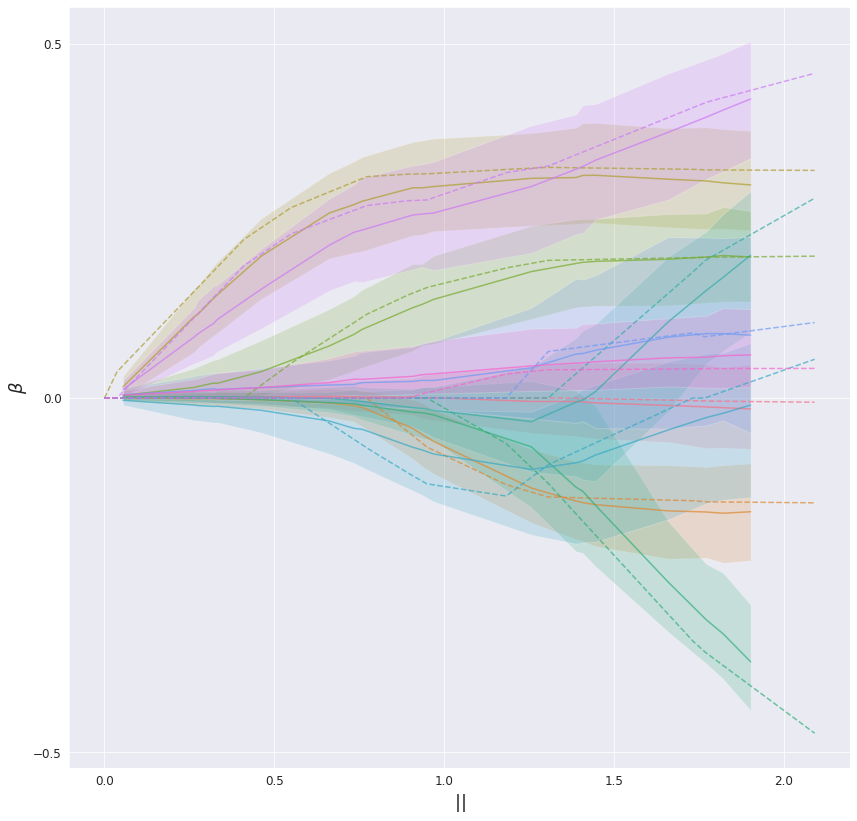

In [17]:
plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params['q'], a=0.95, folder_name=dir_name)

In [35]:
params_flow = dict(q=q,
                  sigma=torch.tensor(0.7),
                  lr=1e-4,
                  epochs=500,
                  T0=20,
                  Tn=1,
                  iter_per_cool_step=25,
                  norm_min=0.01,
                  norm_max=2,#.4
                  lambda_min_exp=-1,
                  lambda_max_exp=3,
                  sample_size=1,
                  context_size=1000,
                  device=device)

In [36]:
flow, loss, loss_T = train_cond_model(flow, X=X_tensor, y=y_tensor, **params_flow)
torch.save(flow.state_dict(), "./models/flow_T_1")

Training loss at step 0: 6040.9 and 289.3 * (T = 20.000)
Training loss at step 1: 5397.3 and 257.6 * (T = 20.000)
Training loss at step 2: 4874.0 and 231.8 * (T = 20.000)
Training loss at step 3: 4267.4 and 202.0 * (T = 20.000)
Training loss at step 4: 3873.4 and 183.1 * (T = 20.000)
Training loss at step 5: 3536.4 and 166.8 * (T = 20.000)
Training loss at step 6: 3068.2 and 144.4 * (T = 20.000)
Training loss at step 7: 2815.3 and 132.3 * (T = 20.000)
Training loss at step 8: 2422.2 and 114.0 * (T = 20.000)
Training loss at step 9: 2191.1 and 103.2 * (T = 20.000)
Training loss at step 10: 1932.7 and 91.7 * (T = 20.000)
Training loss at step 11: 1693.2 and 80.8 * (T = 20.000)
Training loss at step 12: 1487.0 and 72.3 * (T = 20.000)
Training loss at step 13: 1347.5 and 66.4 * (T = 20.000)
Training loss at step 14: 1203.2 and 60.3 * (T = 20.000)
Training loss at step 15: 1084.2 and 56.8 * (T = 20.000)
Training loss at step 16: 986.5 and 53.3 * (T = 20.000)
Training loss at step 17: 917.2 

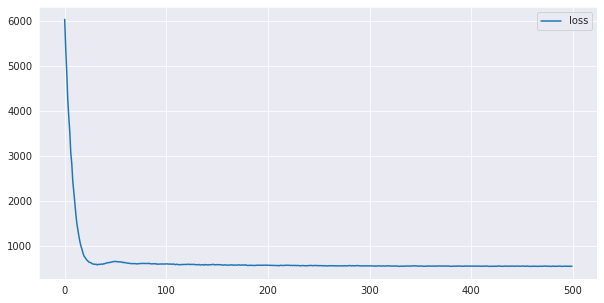

In [37]:
flow.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()

In [38]:
samples_sorted, lambda_sorted, kl_sorted = sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                     lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=1000, n_iter=100, device='cuda')

100%|██████████| 100/100 [00:01<00:00, 78.81it/s]


100%|██████████| 100/100 [00:00<00:00, 1364.14it/s]


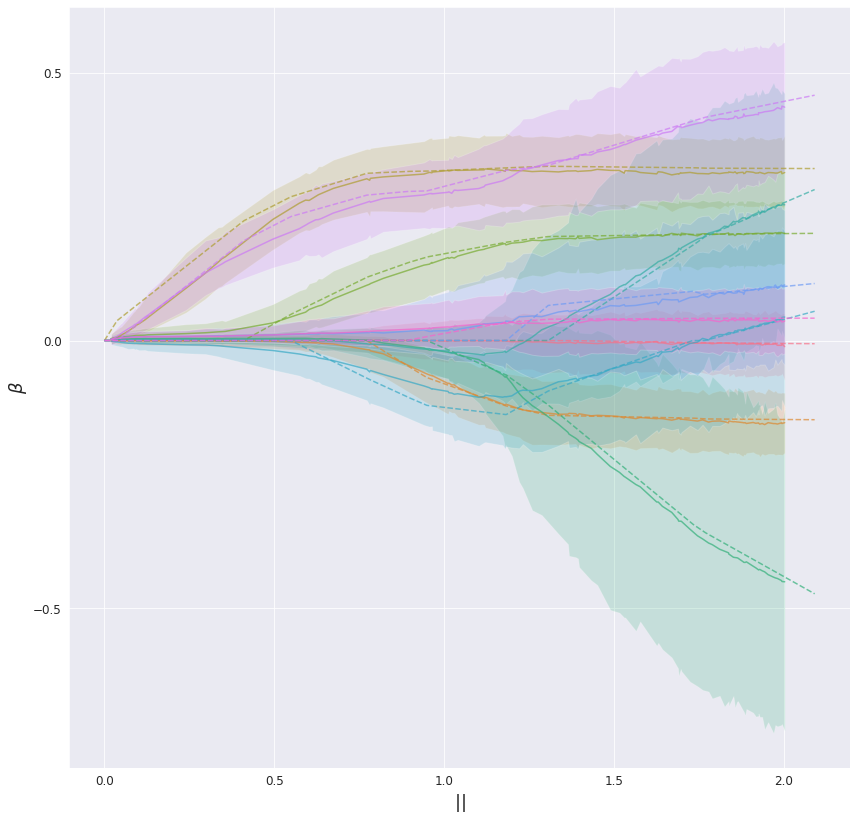

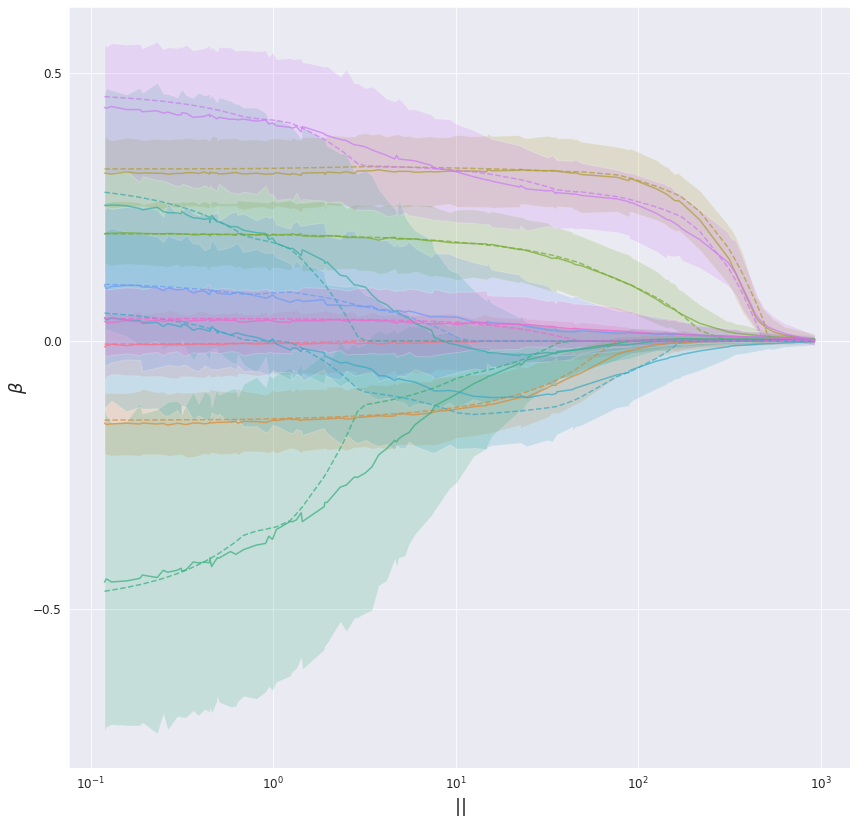

In [39]:
plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, norm=params_flow['q'], a=0.95, folder_name=dir_name)

In [12]:
data_df = pd.DataFrame(np.c_[y_np,X_np], 
                       columns = ['target','0','1','2','3','4','5','6','7','8','9'])

In [13]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('bayes_lasso.R')# Loading the function we have defined in R.
bayes_function = robjects.globalenv['bayes_function']# Reading and processing data
bayes_function_opt_alpha  = (robjects.globalenv)['bayes_function_opt_alpha']# Reading and processing data

In [20]:
alphas_lasso = np.logspace(-1, 3, 20)
coefs, ci_l, ci_r = [], [], []
conf = 0.95
for alpha in alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)
    
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
alpha:  0.1

SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.5e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800

100%|██████████| 20/20 [00:00<00:00, 939.10it/s]


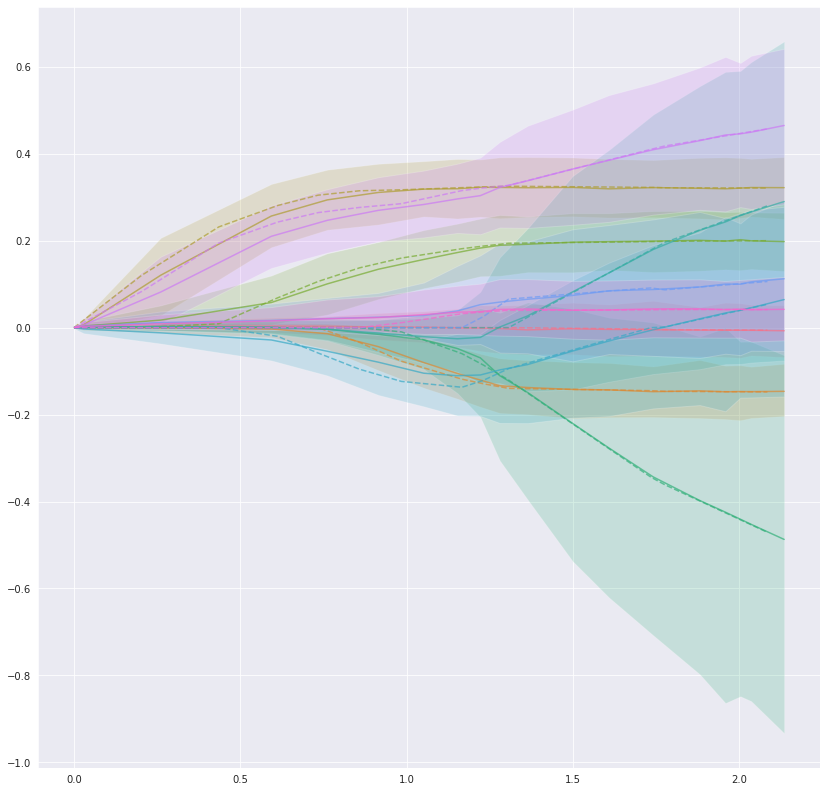

In [21]:
norm = 1.
beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=False).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso/X_np.shape[0]/2)])
sklearn_norm = np.power(np.power(np.abs(beta_sklearn), norm).sum(1), 1 / norm)

sklearn_sorted_idx = sklearn_norm.argsort()
sklearn_norm = sklearn_norm[sklearn_sorted_idx]
sklearn_sorted = beta_sklearn[sklearn_sorted_idx]

coefs_norm = np.power(np.power(np.abs(coefs), norm).sum(1), 1 / norm)
coefs_norm_idx = coefs_norm.argsort()
coefs_norm_sorted = coefs_norm[coefs_norm_idx]
coefs_sorted = coefs[coefs_norm_idx]
ci_l_sorted = ci_l[coefs_norm_idx]
ci_r_sorted = ci_r[coefs_norm_idx]

fig, ax = plt.subplots(figsize=(14, 14))
clrs = sns.color_palette("husl", X_np.shape[-1])
with sns.axes_style("darkgrid"):
    for i in range(X_np.shape[-1]):
        color = clrs[i % X_np.shape[-1]]
        ax.plot(coefs_norm_sorted, coefs_sorted[:,i],alpha=0.7, linewidth=1.5, c=color)
        ax.fill_between(coefs_norm_sorted, ci_l_sorted[:,i], ci_r_sorted[:, i], alpha=0.2, facecolor=color)
        ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, alpha=0.7, c=color)
    plt.savefig("./plots/bayes_lasso.png", dpi=200, bbox_inches='tight')
    plt.show()

100%|██████████| 20/20 [00:00<00:00, 1201.07it/s]


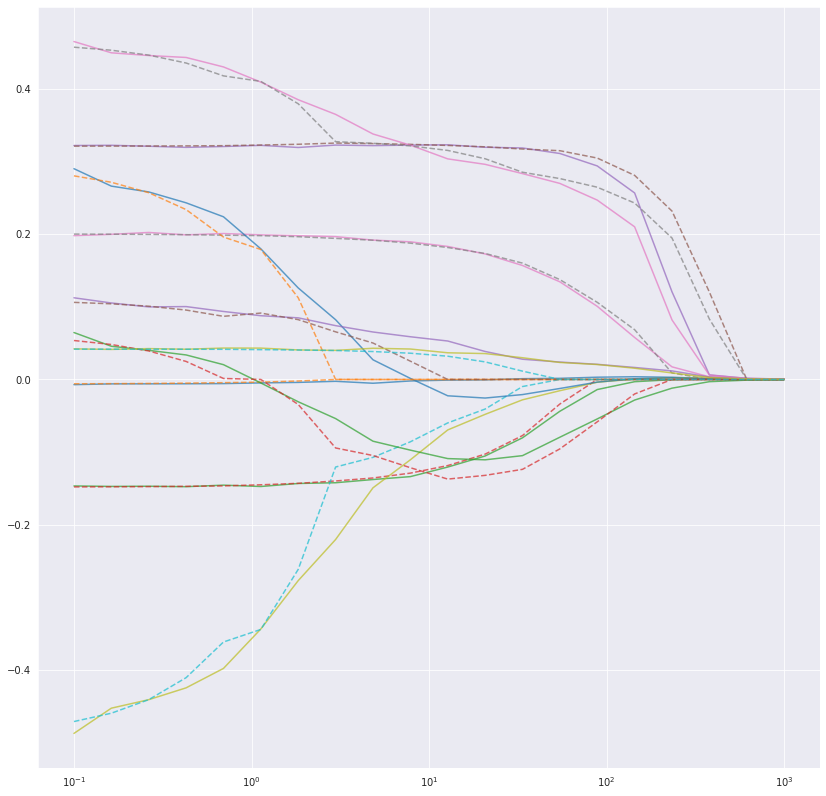

In [22]:
fig, ax = plt.subplots(figsize=(14, 14))
beta_sklearn = np.array(
            [Lasso(alpha=alpha, fit_intercept=True).fit(X_np, y_np).coef_ for alpha in tqdm.tqdm(alphas_lasso/X_np.shape[0]/2)])

with sns.axes_style("darkgrid"):
    for i in range(X_np.shape[-1]):
        # color = [i % X_np.shape[-1]]
        ax.plot(alphas_lasso, coefs[:,i],alpha=0.7, linewidth=1.5)
        ax.plot(alphas_lasso, beta_sklearn[:, i], linestyle='--', linewidth=1.5, alpha=0.7)
        plt.xscale('log')

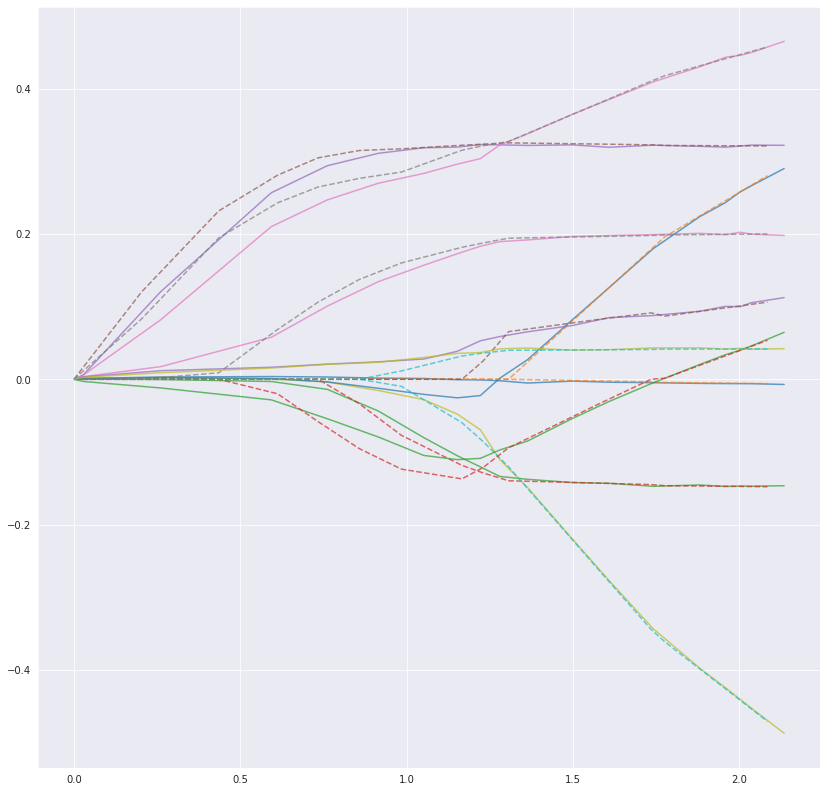

In [23]:
fig, ax = plt.subplots(figsize=(14, 14))
with sns.axes_style("darkgrid"):
    for i in range(X_np.shape[-1]):
        # color = [i % X_np.shape[-1]]
        ax.plot(coefs_norm_sorted, coefs_sorted[:,i],alpha=0.7, linewidth=1.5)
        ax.plot(sklearn_norm, sklearn_sorted[:, i], linestyle='--', linewidth=1.5, alpha=0.7)

### Bayesian linear regression comparison 
- Bayesian linear regression
- Normalizing Flow with Laplace prior and conditioned on $\lambda$
- Normalizing Flow defined on L1 manifold and conditioned on $||\beta||_1=t$

In [9]:
# sample from NF with Laplace prior
flow = build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow.load_state_dict(torch.load("./models/flow_T_1"))
alphas_lasso = np.linspace(-1, 3, 12)
alphas_lasso_torch = torch.from_numpy(alphas_lasso).to(device).to(torch.float32).view(-1,1)
flow_samples, log_probs_samples = flow.sample_and_log_prob(1000, context=alphas_lasso_torch)
flow_samples_np = flow_samples.detach().cpu().numpy()
del flow_samples, log_probs_samples, flow
torch.cuda.empty_cache()
norms_flow = np.abs(flow_samples_np).sum(-1).mean(-1)

In [14]:
# sample from Bayesian Lasso 
coefs, ci_l, ci_r, norms_bayes_lasso = [], [], [], []
conf = 0.95
all_samples_bayes = {}
for alpha in 10**alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    sample_norm = np.abs(bayes_samples).sum(-1).mean()
    all_samples_bayes[f"{sample_norm:.4f}"] = bayes_samples
    norms_bayes_lasso.append(sample_norm)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)
    
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)
norms_bayes_lasso = np.array(norms_bayes_lasso)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
alpha:  0.1

SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 4.3e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800

In [15]:
# sample from NF on manifold
flow_manifold = build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_manifold = 0.5*(norms_bayes_lasso + norms_flow)
norms_flow_torch = torch.from_numpy(norms_flow_manifold).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(10)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(100, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 10/10 [01:20<00:00,  8.01s/it]


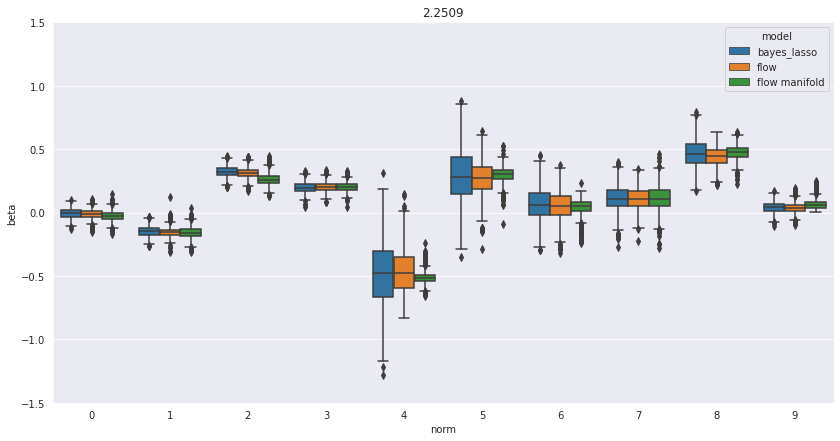

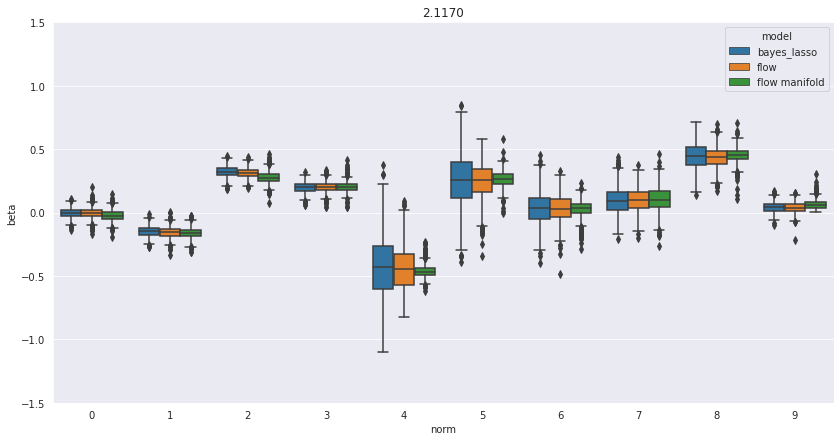

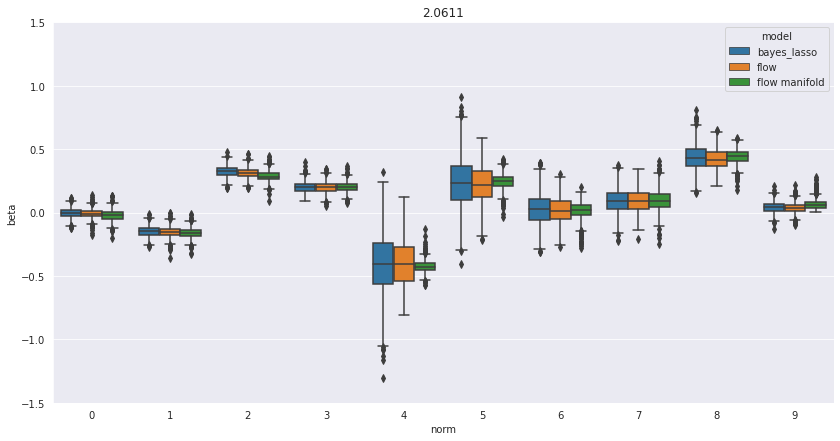

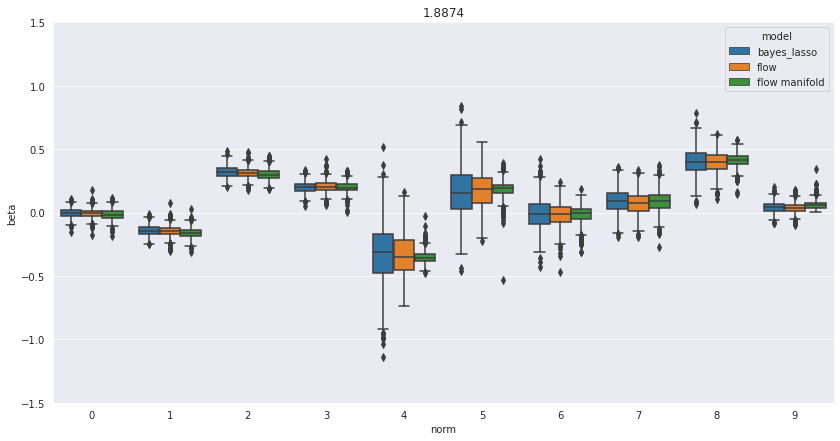

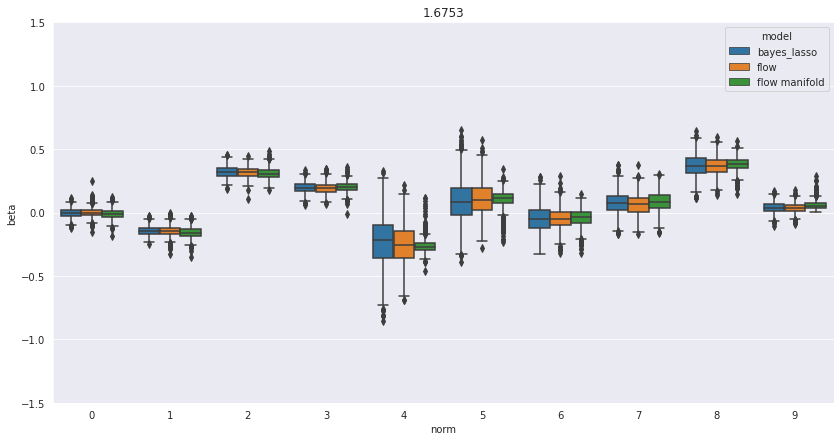

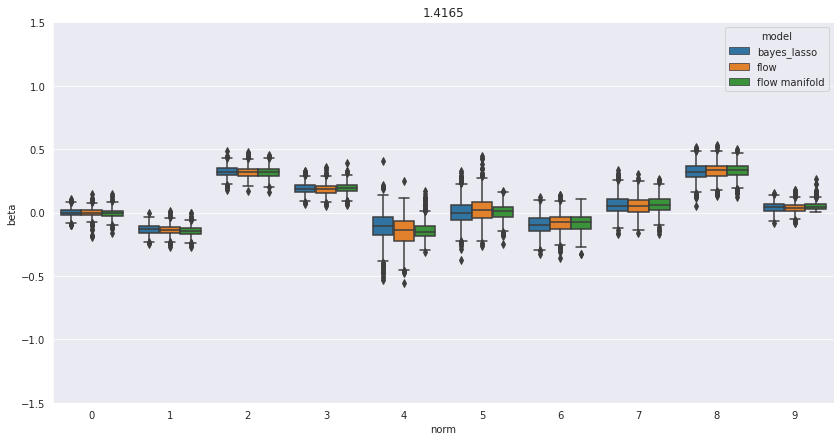

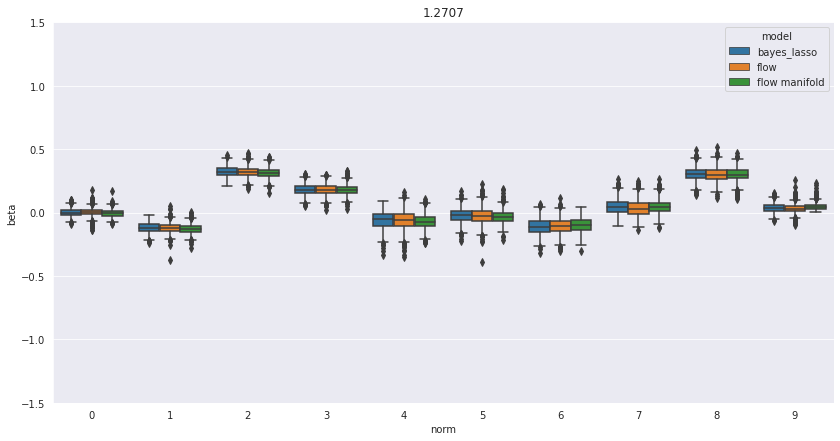

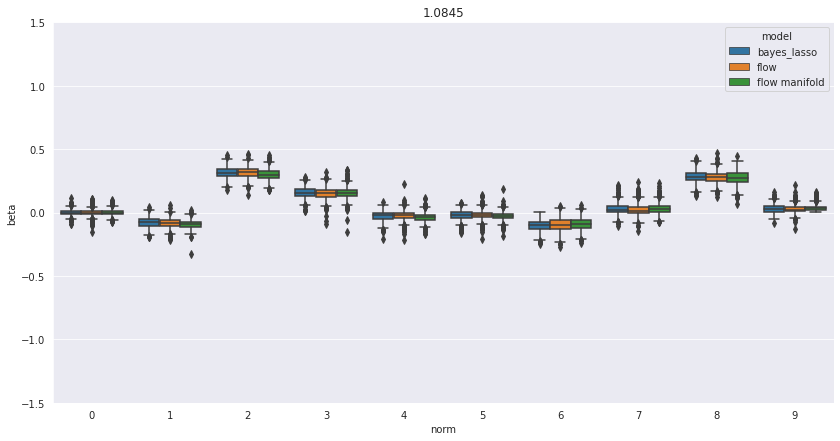

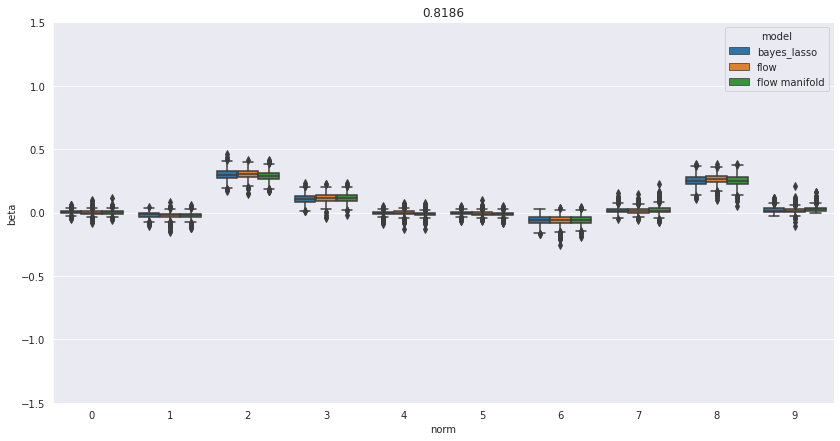

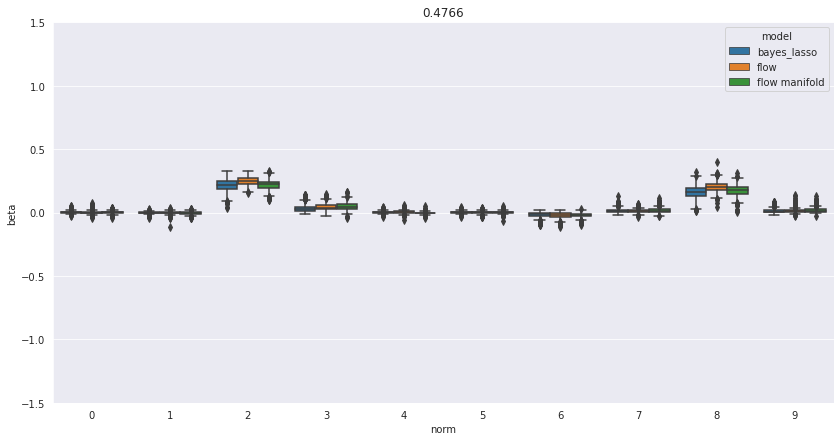

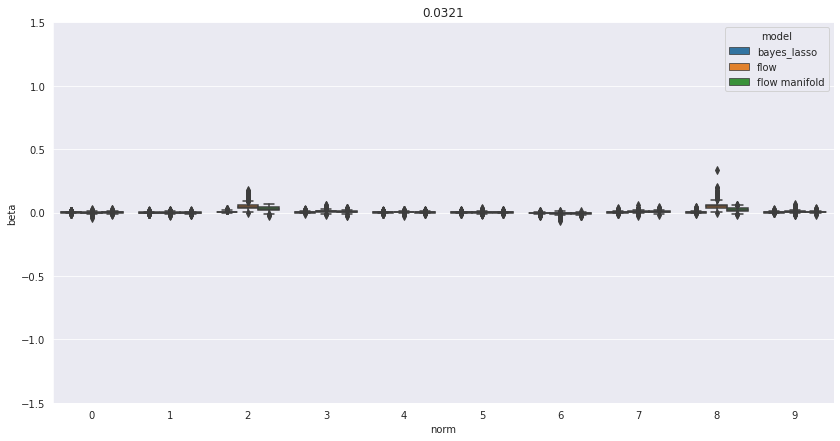

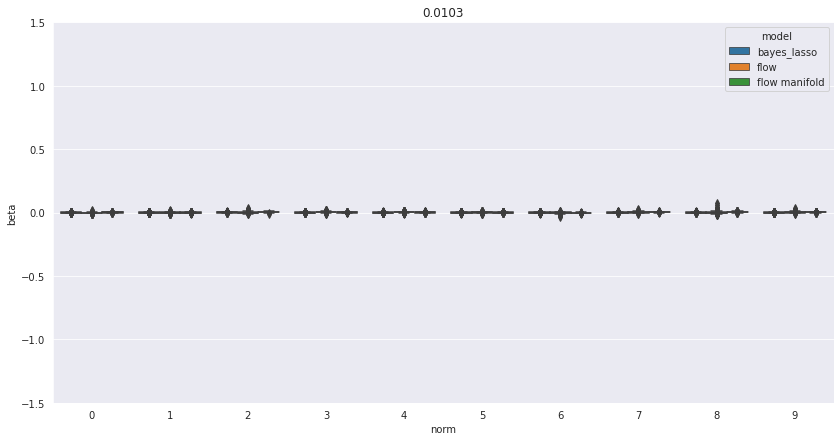

In [19]:
# plot comparison
for i, key_norm in enumerate(all_samples_bayes.keys()):
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(all_samples_bayes[key_norm]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(flow_samples_np[i]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name='norm', value_name="beta")
    sns.boxplot(x="norm", y="beta", hue="model", data=mdf)
    plt.title(key_norm)
    plt.ylim(-1.5,1.5)
    plt.savefig(f"./plots/box_plot_norm_{key_norm}.pdf")
    plt.show()